In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
from sklearn import linear_model

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [2]:
# Path to your Excel file
SOURCE_DATA_SF3 = 'SupplementaryFigure3.xlsx'

# Read specific sheet and ranges
mf = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='A:HY', skiprows=2, nrows=502)
pc = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='HZ:TP', skiprows=2, nrows=502)

# rate is ssc0, drate is wv0
lm_MF = {
    'rate': mf.iloc[:, 0:116].to_numpy().T,
    'drate': mf.iloc[:, 116:232].to_numpy().T,
    'v0': mf.iloc[0, 232],
    'label': 'MF'
}

lm_PC = {
    'rate': pc.iloc[:, 0:151].to_numpy().T,
    'drate': pc.iloc[:, 151:302].to_numpy().T,
    'v0': pc.iloc[0, 302],
    'label': 'PC'
}

# for analyze data
data_mf = lm_MF['rate']
data_pc = lm_PC['rate']

In [3]:
# Load FN cell data

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()
data_fn = np.mean(data_cat_sm, axis=0)

In [22]:
from scipy.ndimage import gaussian_filter1d

Ts = 1000
win = 20 # timewindow (ms), if sampling rate is 1000hz, win=10 is 10ms
# b=[2,3,9,15,14,13,7,1];
# label_ori={'Up','Up right', 'Right', 'Down right',...
#     'Down', 'Down left', 'Left', 'Up left'};

peak_all = []
for data_num in range(np.shape(data_cat)[0]):

    valcat_t = val_cat[data_num]
    datacat_t = data_cat[data_num]

    peak = []
    for a in range(8):

        # Peak
        vv = np.mean(valcat_t[a], axis = 0)
        I = np.where(max(vv) == vv)[0][0]
        s_temp = gaussian_filter1d(np.sum(datacat_t[a], axis = 0), win)
        I2 = np.where(max(s_temp) == s_temp)[0][0]
        peak.append(I2 - I)

    peak_all.append(peak)

onset_delay = np.array(peak_all) / Ts

In [64]:
sp_p = []
for a in range(np.shape(data_cat)[0]):
    
    sp_sum = []
    for b in range(np.shape(data_cat)[1]-1):

        temp = data_cat[a][b]
        sp_size_p = np.shape(temp)[0]
        sp_sum_p = np.sum(temp, axis=0)
        sp_sum.append(sp_sum_p / sp_size_p)

    sp_p.append(sp_sum)

sp_p = np.array(sp_p)

In [115]:
od_idx = onset_delay * Ts

prob = []
for a in range(od_idx.shape[0]):
    temp2 = []
    for b in range(8):
        i = od_idx[a][b].astype(int)
        temp = sp_p[:, :, i + 300]  # Sum 300 because od_idx set to onset timepoint
        temp2.append(temp)

    prob.append(temp2)
prob = np.array(prob)

In [116]:
prob

(67, 8, 67, 8)

In [120]:
prob[0,0,:][0]

array([0.06666667, 0.25      , 0.15384615, 0.1875    , 0.19354839,
       0.20454545, 0.2       , 0.03030303])

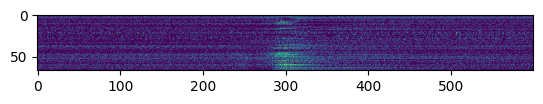

In [74]:
plt.imshow(sp_p[:,1,:])

In [4]:
sp_fn = []
sp_size = []
for a in range(8):

    temp_cat = np.concatenate(data_cat[a])
    sp_size.append(np.shape(temp_cat)[0])
    sp_fn.append(temp_cat)

sp_fn = np.array(sp_fn, dtype = object)
sp_size = np.array(sp_size)

In [29]:
prob = sp_fn / sp_size[0]

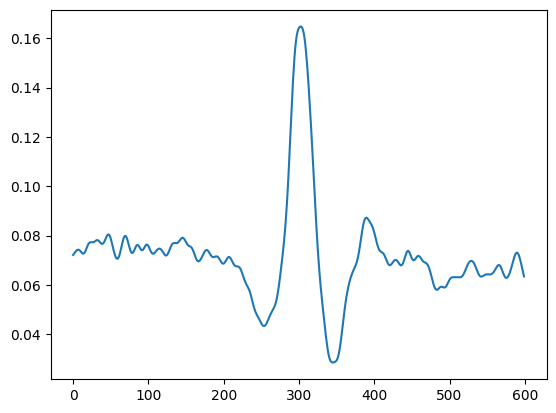

In [21]:
plt.plot(data_fn[2])

In [52]:
data_cat = np.array(data_cat)[:, :8]

In [58]:
np.concatenate(data_cat[1]).shape

(307, 600)

In [50]:
np.shape(data_fn)

(67, 600)

In [32]:
temp = data_cat[1][1]
temp2 = data_cat_sm[1][1]

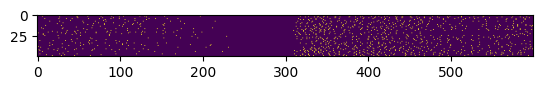

In [21]:
plt.imshow(temp)

In [30]:
Total_p = temp.shape[0]

In [11]:
SS / Total_p

NameError: name 'SS' is not defined

In [24]:
SS = temp.sum(axis=0)

In [48]:
CS = temp.mean(axis=0)
CS_idx = np.argsort(temp2)[::-1][0]

In [4]:
# Distance matrix by cross correlation

from scipy import signal

lags_total=[]
for a in range(len(data_mf)):
    
    plags_total = []
    for b in range(len(data_mf)):
    
        signal1 = data_mf[a]
        signal2 = data_mf[b]
        
        # Calculate cross-correlation
        cross_correlation = signal.correlate(signal1, signal2)
        lags = signal.correlation_lags(len(signal1), len(signal2))
    
        m_idx = np.argmax(cross_correlation)
        plags_total.append(lags[m_idx])
    
    lags_total.append(plags_total)
lags_total = np.array(lags_total)
    

In [5]:
lags_total[0]

array([   0,    2,    3,  -29,    1,    0,   -2,   -7,   15,    0,  -14,
         12,    0,   -2,   -8,    0,   13,    1,   -5,  -11,   14,    0,
       -430,   22,   14,   19,   21,   39,    0,    6,   28,   18,   83,
       -413,   12,  125,   20,   15,   22,    0,    7,   16,   11,   12,
         14,   18,    6,   27,   22,   17,   36,   19,   35,   45,   -9,
         23,   -8,   20,   25,   17,   13,    3,   -3,  168,    8,    2,
         16,   33,   26,   17,   20,    5,   23,   18,   28,   30,   16,
         17,   20,   27,    8,   18,   17,    7,  -88,   15,    7,    3,
          1,   -8,  -21,   14,    2,    6,   -1,   -1,    8,    4,   -8,
         -1,    9,    9,  -10,  -11,   -6,    0,    6,    0,   10,    3,
          1,   14,   -1,   14,   -1, -112])

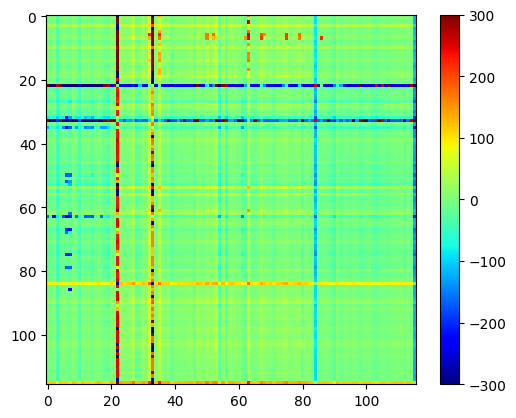

In [6]:
plt.imshow(lags_total, aspect='equal', cmap='jet', origin='upper')
plt.clim(-300, 300)
plt.colorbar()

In [ ]:
# Sorting cells depending on lag

lags_total_cat = []
c_num = []
for a in lags:
    idx_temp = np.where(lags_total == a)
    lags_total_cat.append(idx_temp[0])

    c_num.append(len(idx_temp[0]))

lags_total_cat = np.array(lags_total_cat, dtype = object)